In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv1D, \
                                    UpSampling1D, Embedding, Multiply, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow_addons.layers import GELU, SpectralNormalization as SN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [2]:
%matplotlib inline
file_name = 'plot_tsne'
dir_name = file_name + '_dir'
#os.mkdir(dir_name)

In [43]:
real_electrical_data = np.load('../../data/processed/full_data.npz')['electrical_data']
gen_electrical_data = np.load('../../data/processed/dccgan_full_generated_data.npz')['electrical_data']
wgen_electrical_data = np.load('../../data/processed/normalized_generated_data.npz')['electrical_data']

real_labels = np.load('../../data/processed/full_data.npz')['labels']
gen_labels = np.load('../../data/processed/dccgan_full_generated_data.npz')['labels']
wgen_labels = np.load('../../data/processed/normalized_generated_data.npz')['labels']

data = np.concatenate((real_electrical_data, gen_electrical_data, wgen_electrical_data), axis=0)
labels = np.concatenate((real_labels, gen_labels, wgen_labels), axis=0)

## Define WGANGP Critic

In [4]:
batch_size = 32
seq_length = 8760
nr_features = 6
nr_labels = 5
max_labels = 28
critic_input_shape = (seq_length, nr_features)
discriminator_input_shape = (seq_length, nr_features)

In [5]:
def build_critic():
    # Hyperparameters
    dropout = 0.2
    padding = "causal"
    strides = 2

    # Input
    elecs = Input(shape=(seq_length, nr_features))
    labels = Input(shape=(nr_labels,), dtype='int32')

    label_embedding = SN(Embedding(max_labels, seq_length // nr_labels, input_length=nr_labels))(labels)
    flatten_embedding = Flatten()(label_embedding)
    reshaped_embedding = Reshape((seq_length, 1))(flatten_embedding)

    critic_input = Multiply()([elecs, reshaped_embedding])
    print('\nInput shape for the Critic =', critic_input.shape)

    # Structure
    model = Sequential() # 8760 * 6

    model.add(SN(Conv1D(32, kernel_size=4, padding=padding, strides=strides, input_shape=critic_input_shape)))
    model.add(GELU())
    model.add(Dropout(dropout))

    model.add(SN(Conv1D(64, kernel_size=4, padding=padding, strides=strides)))
    model.add(GELU())
    model.add(Dropout(dropout))

    model.add(SN(Conv1D(128, kernel_size=4, padding=padding, strides=strides)))
    model.add(GELU())
    model.add(Dropout(dropout))

    model.add(SN(Conv1D(256, kernel_size=4, padding=padding, strides=strides)))
    model.add(GELU())
    model.add(Dropout(dropout))

    model.add(SN(Conv1D(512, kernel_size=4, padding=padding, strides=strides)))
    model.add(GELU())
    model.add(Dropout(dropout))

    model.add(SN(Conv1D(1024, kernel_size=4, padding=padding, strides=strides)))
    model.add(GELU())
    model.add(Dropout(dropout))

    model.add(Flatten())
    #model.add(SN(Dense(1)))

    print('Critic Structure:')
    model.build((batch_size, *critic_input_shape))
    model.summary()

    # Result
    res = model(critic_input)

    return Model([elecs, labels], res, name="critic")

## Loading the Critic

In [6]:
critic = build_critic()
critic.load_weights('./maybe_better_v8_newfft10_corect_dir/ckpt/critic_weights_500.ckpt')


Input shape for the Critic = (None, 8760, 6)
Critic Structure:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_normalization_1 (Sp (32, 4380, 32)            832       
_________________________________________________________________
gelu (GELU)                  (32, 4380, 32)            0         
_________________________________________________________________
dropout (Dropout)            (32, 4380, 32)            0         
_________________________________________________________________
spectral_normalization_2 (Sp (32, 2190, 64)            8320      
_________________________________________________________________
gelu_1 (GELU)                (32, 2190, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (32, 2190, 64)            0         
__________________________________________________________

C:\Users\silvi\anaconda3\envs\p38\lib\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: Default value of `approximate` is changed from `True` to `False`
  return py_builtins.overload_of(f)(*args)


In [44]:
data_features = critic.predict([data, labels])

In [45]:
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data_features)
print(sum(pca.explained_variance_ratio_))

0.9979482451017248


In [46]:
tsne = TSNE(perplexity=40.0, n_iter_without_progress=100, init='pca', n_jobs=-1)
data_tsne = tsne.fit_transform(data_pca)

In [47]:
df_data = {'X': data_tsne[:, 0],
        'Y': data_tsne[:, 1],
        'Type': ['Real'] * 507 + ['cDCGAN'] * 5000 + ['cWGAN-GP-SN'] * 5000}
  
df = pd.DataFrame(df_data)
print(df)

               X          Y         Type
0      48.191303  -3.739916         Real
1      35.720173  10.611870         Real
2     -15.272388 -45.250332         Real
3     -15.335253 -45.252216         Real
4      -0.603980  -3.615303         Real
...          ...        ...          ...
10502  59.069920  38.275166  cWGAN-GP-SN
10503  -0.443871  58.957279  cWGAN-GP-SN
10504  40.073215  27.793329  cWGAN-GP-SN
10505 -19.005846  -4.620934  cWGAN-GP-SN
10506 -56.640545 -31.423246  cWGAN-GP-SN

[10507 rows x 3 columns]


<AxesSubplot:xlabel='X', ylabel='Y'>

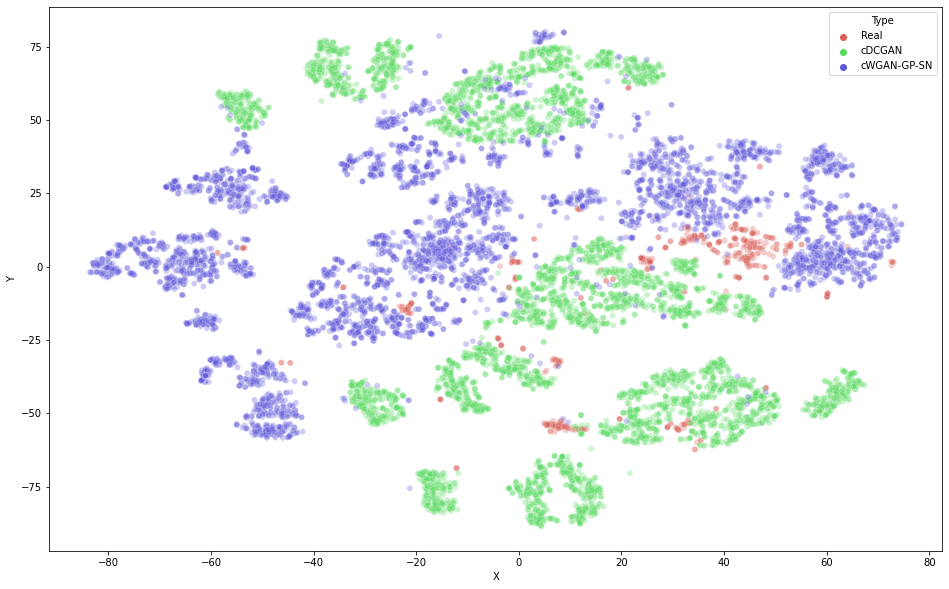

In [48]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='X', y='Y',
    hue="Type",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.3
)